In [1]:
import pandas as pd

df_raw = pd.read_csv('gender-classification.csv', encoding='latin1')

In [2]:
# 目的変数をいじる

## 目的変数を確認
obj_col = 'gender'
print('生データ\n{}'.format(df_raw[obj_col].value_counts()))

## male と femaleを抽出
df = df_raw.loc[ (df_raw[obj_col]=='male') | (df_raw[obj_col]=='female')]

## indexを振り直さないとlocメソッドでerrorが出る
df = df.reset_index(drop=True)

##ラベルを整数に変換
df.loc[ df[obj_col]=='male' , obj_col] = 0
df.loc[ df[obj_col]=='female' , obj_col] = 1

## 目的変数の型変換
df.loc[:, obj_col ] = df.loc[:, obj_col ].astype(int)

print('修正後のデータ\n{}'.format(df[obj_col].value_counts()))

生データ
female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64
修正後のデータ
1    6700
0    6194
Name: gender, dtype: int64


In [9]:
# 説明変数をいじる
## description : 頻度表
## text : 分散表現 (word2vec or fasttext) + 品詞の並び方
## name : 文字単位
## link_color : RGBで各次元を形成
## sidebar_color : RGBで各次元を形成
## fav_number : 不明
## retweet_count : 不明
## profileimage : 学習済みモデルから分類する? コスト高そう そもそも人かどうか判断できる時点で予測するまでもない

## 性別判定の信頼度が1.0を対象に学習する
df = df.loc[ df['gender:confidence'] >=1.0 ]
df = df.reset_index(drop=True)

In [4]:
import re

def remove_urls(text):
    
    urls = [g[0] for g in re.findall(r'((https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+))', text)]
    
    for url in sorted(urls,key=lambda x:-len(x)):
    
        text = text.replace(url,'')
        
    return text

def remove_mentions(text):
    
    mentions = [g[0] for g in re.findall(r'@\w+', text)]
    
    for mention in sorted(mentions,key=lambda x:-len(x)):
    
        text = text.replace(mention,'')
        
    return text

def remove_rt(text):
    
    rts = [g[0] for g in re.findall(r'\s?RT\s', text)]
    
    for rt in sorted(rts,key=lambda x:-len(x)):
    
        text = text.replace(rt,'')
        
    return text

In [5]:
df.text = df.text.map(remove_urls)
df.text = df.text.map(remove_mentions)
df.text = df.text.map(remove_rt)

In [11]:
df.text.apply(lambda x: len(x)).describe()

count    10020.000000
mean        88.798902
std         33.100038
min          5.000000
25%         62.000000
50%         89.000000
75%        115.000000
max        425.000000
Name: text, dtype: float64

In [10]:
import numpy as np
from keras.utils import to_categorical

y = to_categorical(np.asarray(df.gender.values).astype('float32'))

In [12]:
# train test split
from sklearn.model_selection import train_test_split

df_x_train, df_x_test, y_train, y_test = train_test_split(df.text.values, y, test_size = 0.1, random_state = 0, stratify=df.gender.values)

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(
    char_level=False,
    lower=True,
)

In [26]:
tokenizer.fit_on_texts(df_x_train)

max_len = 115

train_sequences = tokenizer.texts_to_sequences(df_x_train)
x_train = pad_sequences(train_sequences, maxlen=max_len)

test_sequences = tokenizer.texts_to_sequences(df_x_test)
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [27]:
idx = tokenizer.word_index

In [29]:
dim = len(idx)
dim

21089

In [30]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(Embedding(dim, 128, input_length=max_len))
model.add(Bidirectional(LSTM(max_len)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 115, 128)          2699392   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 230)               224480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 230)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 462       
Total params: 2,924,334
Trainable params: 2,924,334
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(patience=5, monitor='val_loss')])

Train on 8116 samples, validate on 902 samples
Epoch 1/20
8116/8116 [==============================] - 96s 12ms/step - loss: 0.6725 - acc: 0.5731 - val_loss: 0.6544 - val_acc: 0.5920
Epoch 2/20
8116/8116 [==============================] - 94s 12ms/step - loss: 0.5386 - acc: 0.7647 - val_loss: 0.6781 - val_acc: 0.6286
Epoch 3/20
8116/8116 [==============================] - 94s 12ms/step - loss: 0.2522 - acc: 0.8993 - val_loss: 0.8269 - val_acc: 0.6197
Epoch 4/20
8116/8116 [==============================] - 94s 12ms/step - loss: 0.1161 - acc: 0.9611 - val_loss: 1.1476 - val_acc: 0.5987
Epoch 5/20
8116/8116 [==============================] - 94s 12ms/step - loss: 0.0698 - acc: 0.9786 - val_loss: 1.3149 - val_acc: 0.6031
Epoch 6/20
8116/8116 [==============================] - 95s 12ms/step - loss: 0.0451 - acc: 0.9867 - val_loss: 1.4750 - val_acc: 0.5965


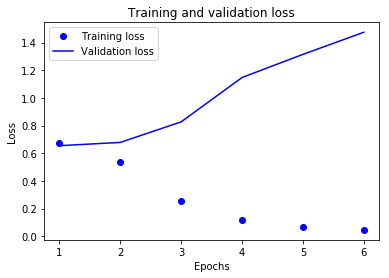

In [32]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

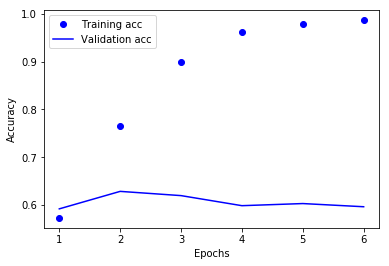

In [33]:
plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
model.evaluate(x_test, y_test)

1002/1002 [==============================] - 3s 3ms/step


[1.5348801665796252, 0.60279441093970199]